This file provides scripts for accessing and using the infographics metadata (for the 63K and 29K datasets, stored in infographics60K_metadata.pckl) as well as for downloading the infographics images referred to.

In [1]:
import pickle as pkl
from pprint import pprint
import numpy as np
import time
import urllib
import urllib.request
import os
import pandas as pd 
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

class infographicInfo:
    def __init__(self,currow):
        self.views = int(currow['views']);
        self.likes = int(currow['likes']);
        self.shares = int(currow['shares']);
        self.comments = int(currow['comments']);
        self.staffPick = currow['staffPick'];
        self.imgurl = currow['url_img_ful_res'];
        self.mainurl = currow['url'];
        self.title = currow['igTitle'];
        self.category = currow['category'];
        self.description = currow['description'];
        self.title = currow['title'];
        self.tags = currow['tags'];

# Get the meta-data for the infographic dataset: #

In [2]:
infographicList = pkl.load(open("infographics60K_metadata.pckl", "rb"))

In [3]:
print('We include meta-data obtained from Visual.ly for %d infographics. We call this the 63K dataset.\n'\
       'No additional filtering or annotations are provided beyond what is already found on Visual.ly.\n'\
       'This is the original, uncurated data.\n'\
      'Note: we do not provide the downloaded images themselves, only the URLs for download.'
      %(len(infographicList)))

We include meta-data obtained from Visual.ly for 63738 infographics. We call this the 63K dataset.
No additional filtering or annotations are provided beyond what is already found on Visual.ly.
This is the original, uncurated data.
Note: we do not provide the downloaded images themselves, only the URLs for download.


In [4]:
# Here we can see all the meta-data that is available per infographic.
pprint(infographicList[0].__dict__)

{'category': 'Business',
 'comments': 7,
 'description': "Visually's latest report dives into the relationship between "
                'marketers and creatives.',
 'imgurl': 'http://thumbnails.visually.netdna-cdn.com/marketers-vs-creatives-communication-breakdown-thumbnail_5639568df0acc_h1000.png',
 'imname': 'marketers-vs-creatives-communication-breakdown-thumbnail_5639568df0acc.png',
 'likes': 150,
 'mainurl': 'http://visual.ly/marketers-vs-creatives-communication-breakdown',
 'shares': 75,
 'staffPick': 'FALSE',
 'tags': ['marketing', 'content', 'markting in business', 'designers'],
 'title': 'Marketers vs Creatives: Communication Breakdown',
 'transcript': [],
 'views': 8760}


In [5]:
n1 = len([i for i in range(len(infographicList)) if len(infographicList[i].title)])
n2 = len([i for i in range(len(infographicList)) if len(infographicList[i].description)])
n3 = len([i for i in range(len(infographicList)) if len(infographicList[i].transcript)])
tot = float(len(infographicList))
print('%d (%d%%) of the infographics have titles, %d (%d%%) have descriptions, %d (%d%%) have associated transcripts.'\
%(n1,100*n1/tot,n2,100*n2/tot,n3,100*n3/tot))
  

63727 (99%) of the infographics have titles, 60337 (94%) have descriptions, 1193 (1%) have associated transcripts.


### Notes about metadata ###
* category: 1 of 26 categories (listed in https://github.com/cvzoya/visuallydata/blob/master/29kfiles/map_labels_cats.txt)
* comments: # of comments about this infographic on the Visual.ly page (a quantification of interest/popularity)
* description: the free-form description provided by the infographic's designer (can be used for caption prediction tasks)
* imgurl: the URL from which the image can be downloaded (at high resolution)
* imname: the filename of the image
* likes: # of likes this infographic received on Visual.ly (a quantification of interest/popularity)
* mainurl: the URL of the page containing both the infographic image and metadata on Visual.ly
* shares: # of shares this infographic received on Visual.ly (a quantification of interest/popularity)
* staffPick: whether this infographic was a staff pick at Visual.ly (a binary quality attribute)
* tags: free-form tags (multiple) given to the infographic by the designer
* title: the title of the infographic (can be used for caption prediction tasks)
* transcript: about 1K infographics (see cell above) come with transcripts of the content (can be used for captioning and summarization tasks)
* views: # of times this infographic was viewe on Visual.ly (a quantification of interest/popularity)

In [6]:
lines = open('29kfiles/train.txt','rb').readlines()
trainfiles = [l.split()[0] for l in lines] # train files
lines = open('29kfiles/test.txt','rb').readlines()
testfiles = [l.split()[0] for l in lines] # test files
print('Out of the %d original infographics, we curated a subset of %d infographics. We call this the 29K dataset.\n'\
      'For various learning tasks in our paper, we split them into %d training images and %d test images.'
     %(len(infographicList),len(trainfiles)+len(testfiles),len(trainfiles),len(testfiles)))

Out of the 63738 original infographics, we curated a subset of 28973 infographics. We call this the 29K dataset.
For various learning tasks in our paper, we split them into 26076 training images and 2897 test images.


https://github.com/cvzoya/visuallydata/blob/master/29kfiles/train.txt contains a list (one filename per line) of the training infographics. https://github.com/cvzoya/visuallydata/blob/master/29kfiles/test.txt contains a list (one filename per line) of the test infographics.

Each filename (imname) is followed by an integer (0-25) that corresponds to the category of the infographic (see https://github.com/cvzoya/visuallydata/blob/master/29kfiles/map_labels_cats.txt) and (multiple) additional integers (0-390) that correspond to the tags of an infographic (see https://github.com/cvzoya/visuallydata/blob/master/29kfiles/map_labels_tags.txt).

In [7]:
lines = open('29kfiles/train.txt','rb').readlines()
alltags = [l.split()[2:] for l in lines]
allcats = [l.split()[1] for l in lines]
lines2 = open('29kfiles/test.txt','rb').readlines()
alltags.extend([l.split()[2:] for l in lines2])
allcats.extend([l.split()[1] for l in lines2])

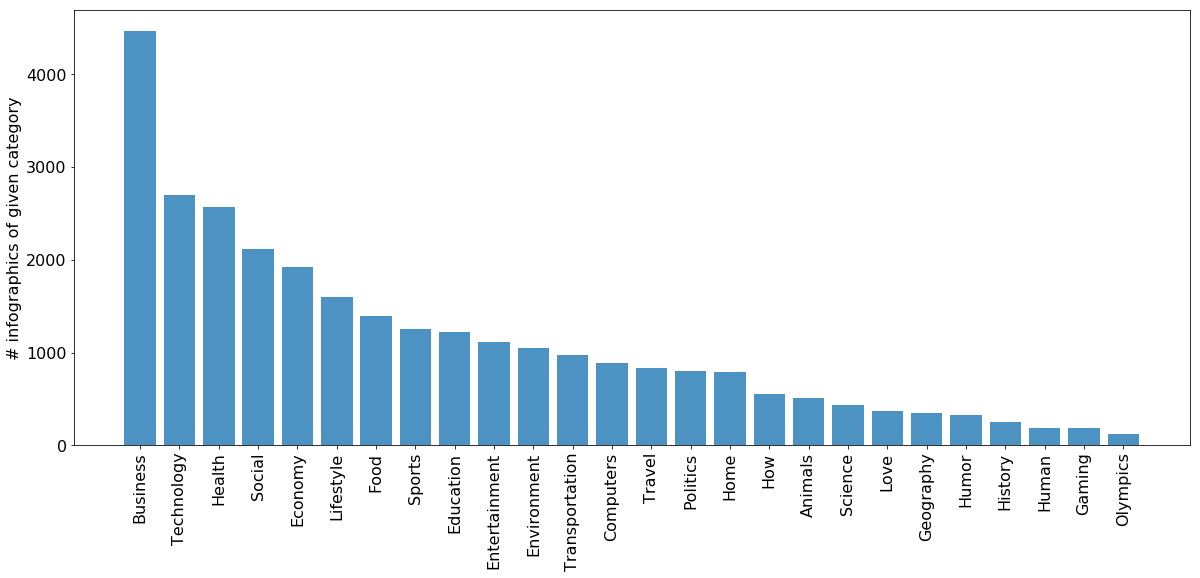

In [8]:
# plot the distribution of categories across the infographics

lines = open('29kfiles/map_labels_cats.txt','rb').readlines()
cat_id_to_name = {l.split()[0]:l.split()[1].decode('utf-8') for l in lines}

dict_of_cats = Counter(allcats)
cat_names = []
cat_counts = []
for key,val in dict_of_cats.items():
    cat_names.append(cat_id_to_name[key])
    cat_counts.append(val)

inds = np.argsort(cat_counts)[::-1]
cat_names = [cat_names[i] for i in inds]
cat_counts = [cat_counts[i] for i in inds]

plt.figure(figsize=(20, 8));
plt.bar(range(len(cat_names)), cat_counts, align='center', alpha=0.8);
plt.xticks(range(len(cat_names)), cat_names,rotation=90,fontsize=16);
plt.yticks(fontsize=16);
plt.ylabel('# infographics of given category',fontsize=16);

In [9]:
ntags = [len(t) for t in alltags]
print('The average number of tags per infographic: %d (range: %d-%d).'
      %(np.mean(ntags),min(ntags),max(ntags)))

The average number of tags per infographic: 2 (range: 1-9).


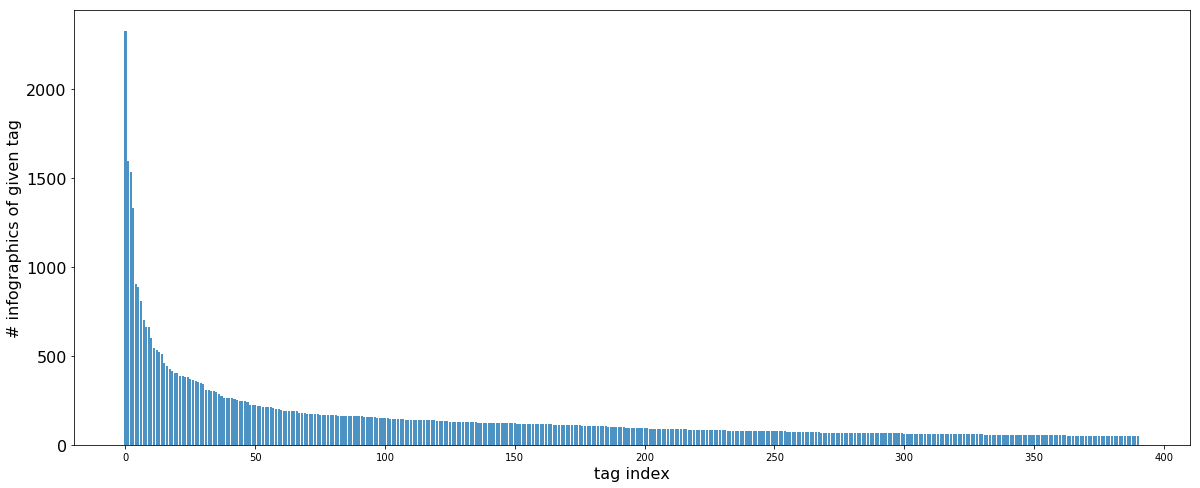

In [10]:
# plot the distribution of tags across the infographics

lines = open('29kfiles/map_labels_tags.txt','rb').readlines()
tag_id_to_name = {l.split()[0]:l.split()[1].decode('utf-8') for l in lines}

alltags_flat = [item for sublist in alltags for item in sublist]
dict_of_tags = Counter(alltags_flat)
tag_names = []
tag_counts = []
for key,val in dict_of_tags.items():
    tag_names.append(tag_id_to_name[key])
    tag_counts.append(val)

inds = np.argsort(tag_counts)[::-1]
tag_names = [tag_names[i] for i in inds]
tag_counts = [tag_counts[i] for i in inds]

plt.figure(figsize=(20, 8));
plt.bar(range(len(tag_names)), tag_counts, align='center', alpha=0.8);
plt.yticks(fontsize=16);
plt.ylabel('# infographics of given tag',fontsize=16);
plt.xlabel('tag index',fontsize=16);

In [11]:
ntop = 20 # print tags occuring most numbers of times in this dataset
pd.DataFrame({'# occurrences':tag_counts[:ntop]},index=tag_names[:ntop])

NameError: name 'pd' is not defined

### Notes about 29K dataset and tags ###

These tags were curated from the original free-form tags of the 63K dataset. 
Many of the original tags are either semantically
redundant or have too few instances. Redundant tags
were merged using WordNet and manually, and only
the 391 tags with at least 50 image instances each were retained.
To produce the final 29K dataset, we further filtered
images to contain a category annotation, and at least one of the
391 tags.

# Download the infographic images: #

### Download all 63K images: ###

In [ ]:
#infographicList = pkl.load(open("infographics60K_metadata.pckl", "rb"))

outdir = 'fullsize-60k' # where to save the downloaded image files
if not os.path.exists(outdir):
    os.makedirs(outdir)

for i in range(len(infographicList)):
    
    # use this url directly to obtain images (with limits on image width, indicated by '_w1000' in the filename)
    url = infographicList[i].imgurl 
    
    # use this adjusted url to obtain full-size images
    usp = url.rfind('_') # underscore position
    pp = url.rfind('.') # period position
    fullsizeimurl = url[:usp] + url[pp:] # full size image url
    
    # the above is identical to just using the following, except for 3 images that have exceptionally long filenames
    # (image IDs: 8865, 44810, 45886)
    imname = infographicList[i].imname 
    fullurl = 'http://thumbnails.visually.netdna-cdn.com/%s'%(imname)
    
    #urllib.urlretrieve(fullsizeimurl, os.path.join(outdir,imname)) # python 2
    urllib.request.urlretrieve(fullsizeimurl, os.path.join(outdir,imname)) # python 3
    
    time.sleep(1) # to avoid launching too many download requests at once
    break # remove break to keep downloading images


### Download just the 2.8K test images: ###

In [ ]:
outdir = 'test-images' # where to save the downloaded image files
if not os.path.exists(outdir):
    os.makedirs(outdir)

lines = open('29kfiles/test.txt','rb').readlines()
testfilenames = [l.split()[0] for l in lines]

for i in range(len(testfilenames)):
    imname = testfilenames[i].decode('utf-8')
    fullurl = 'http://thumbnails.visually.netdna-cdn.com/%s'%(imname)
    
    #urllib.urlretrieve(fullsizeimurl, os.path.join(outdir,imname)) # python 2
    urllib.request.urlretrieve(fullsizeimurl, os.path.join(outdir,imname)) # python 3

    # to monitor progress:
    if i%50==0:
        print('.\n')
    else:
        print('.', end='')
        
    time.sleep(1) # to avoid launching too many download requests at once
    
    break # remove break to keep downloading images
    